In [1]:
import tensorflow as tf
#print("TensorFlow version: ", tf.__version__)
#tf.debugging.set_log_device_placement(True)
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
#import os
#os.environ["CUDA_VISIBLE_DEVICES"]='1'
#os.environ["CUDA_VISIBLE_DEVICES"]='0'

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1750878660040098879
xla_global_id: -1
]


In [2]:
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
import numpy as np

In [3]:
batch_size = 100
original_dim = 784
latent_dim = 2
intermediate_dim = 256
epochs = 50
epsilon_std = 1.0

In [4]:
#def sampling(args: tuple):
#    z_mean, z_log_var = args
def sampling(z_mean, z_log_var):
    #그냥랜덤값?(임의의 양수? 입실론?)
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0., stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [5]:
x = Input(shape=(original_dim,), name="input")
h = Dense(intermediate_dim, activation='relu', name="encoding")(x)
z_mean = Dense(latent_dim, name="mean")(h)
z_log_var = Dense(latent_dim, name="log-variance")(h)

#z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
z = sampling(z_mean, z_log_var)

#encoder = Model(x, [z_mean, z_log_var, z], name="encoder")
encoder = Model(x, z, name="encoder")

shape: KerasTensor(type_spec=TensorSpec(shape=(), dtype=tf.int32, name=None), inferred_value=[None], name='tf.__operators__.getitem/strided_slice:0', description="created by layer 'tf.__operators__.getitem'")


In [6]:
input_decoder = Input(shape=(latent_dim,), name="decoder_input")
decoder_h = Dense(intermediate_dim, activation='relu', name="decoder_h")(input_decoder)
x_decoded = Dense(original_dim, activation='sigmoid', name="flat_decoded")(decoder_h)

decoder = Model(input_decoder, x_decoded, name="decoder")

In [7]:
#output_combined = decoder(encoder(x)[2])
#output_combined = decoder(z)
#vae = Model(x, output_combined)
vae = Model(x, decoder(z))
vae.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input (InputLayer)             [(None, 784)]        0           []                               
                                                                                                  
 encoding (Dense)               (None, 256)          200960      ['input[0][0]']                  
                                                                                                  
 mean (Dense)                   (None, 2)            514         ['encoding[0][0]']               
                                                                                                  
 log-variance (Dense)           (None, 2)            514         ['encoding[0][0]']               
                                                                                              

In [8]:
kl_loss = - 0.5 * K.sum(1 + z_log_var - K.exp(z_log_var) - K.square(z_mean), axis=-1)

vae.add_loss(K.mean(kl_loss) / 784.)
vae.compile(optimizer='rmsprop', loss="binary_crossentropy")

In [9]:
#(x_train, y_train), (x_test, y_test) = mnist.load_data()
from tensorflow.keras.datasets import fashion_mnist
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

#일짜로 쭉펴기
#x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
#x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
x_train = x_train.reshape(len(x_train), 28*28)
x_test = x_test.reshape(len(x_test), 28*28)

In [10]:
vae.fit(x=x_train, y=x_train, shuffle=True, epochs=epochs, batch_size=batch_size)

Epoch 1/50
600/600 [==============================] - 4s 6ms/step - loss: 0.3754
Epoch 2/50
600/600 [==============================] - 4s 7ms/step - loss: 0.3454
Epoch 3/50
600/600 [==============================] - 4s 7ms/step - loss: 0.3406
Epoch 4/50
600/600 [==============================] - 5s 8ms/step - loss: 0.3383
Epoch 5/50
600/600 [==============================] - 4s 7ms/step - loss: 0.3366
Epoch 6/50
600/600 [==============================] - 4s 6ms/step - loss: 0.3353
Epoch 7/50
600/600 [==============================] - 4s 7ms/step - loss: 0.3343
Epoch 8/50
600/600 [==============================] - 5s 8ms/step - loss: 0.3335
Epoch 9/50
600/600 [==============================] - 4s 7ms/step - loss: 0.3328
Epoch 10/50
600/600 [==============================] - 5s 8ms/step - loss: 0.3323
Epoch 11/50
600/600 [==============================] - 5s 8ms/step - loss: 0.3319
Epoch 12/50
600/600 [==============================] - 5s 9ms/step - loss: 0.3315
Epoch 13/50
600/600 [====

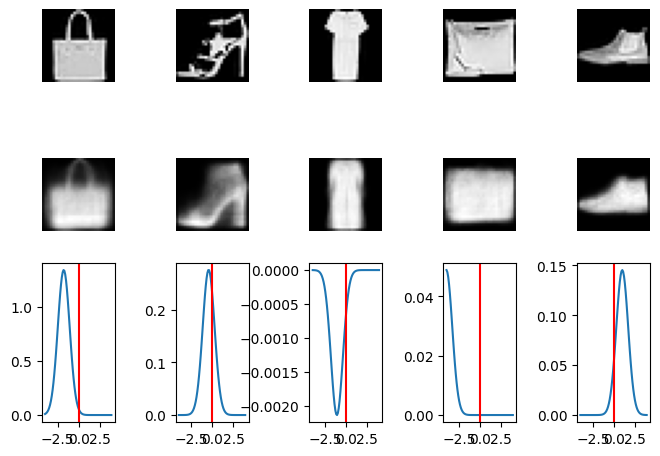

In [11]:
# sample = x_test[1].reshape(1,28*28)
# enc_sample = encoder(sample)
# decoded_imgs = decoder(enc_sample[2]).numpy()
# decoded_imgs = vae.predict(sample)

import matplotlib.pyplot as plt
def drawimg(n, imgs):
    plt.subplot(3, 5, n+1)
    plt.gray()
    plt.imshow(imgs)
    plt.axis('off')

import math
def normal_pdf(x, mu=0, sigma=1):
    return(math.exp(-(x-mu)**2)/(2*sigma**2))/(math.sqrt(2*math.pi)*sigma)

def drawdist(n, z_m, z_var):
    xs = [x/10 for x in range(-40, 40)]
    plt.subplot(3, 5, n+1)
    plt.plot(xs, [normal_pdf(x, mu=z_m, sigma=z_var) for x in xs], '-', label='mu=0, sigma=1')
    plt.axvline(x=0, color='red')
    #plt.ylim([-5, 5])
    #plt.axis('off')
    #plt.show()
    
import random
for idx, n in enumerate(random.sample(range(10000), 5)):
    sample = x_test[n].reshape(1, 28*28)
    drawimg(idx, sample.reshape(28,28))
    decoded_img = vae.predict(sample)
    drawimg(5+idx, decoded_img.reshape(28,28))
    enc_sample = encoder(sample).numpy()[0]
    drawdist(10+idx, enc_sample[0], enc_sample[1])
    
#plt.figure(figsize=(5, 3))    
plt.tight_layout(pad=0)
plt.show()



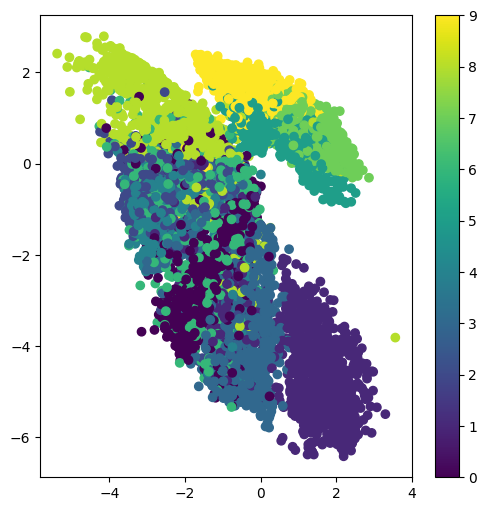

In [12]:
# display a 2D plot of the digit classes in the latent space
# x_test_encoded = encoder.predict(x_test, batch_size=batch_size)#[0]
# plt.figure(figsize=(6, 6))
# plt.scatter(x_test_encoded[:,0], x_test_encoded[:,1], c=y_test, cmap='viridis')

test_z = encoder.predict(x_test)
test_z_mean = test_z[:,0]
test_z_log_var = test_z[:,1]
plt.figure(figsize=(6, 6))
plt.scatter(test_z_mean, test_z_log_var, c=y_test, cmap='viridis')
plt.colorbar()
plt.show()

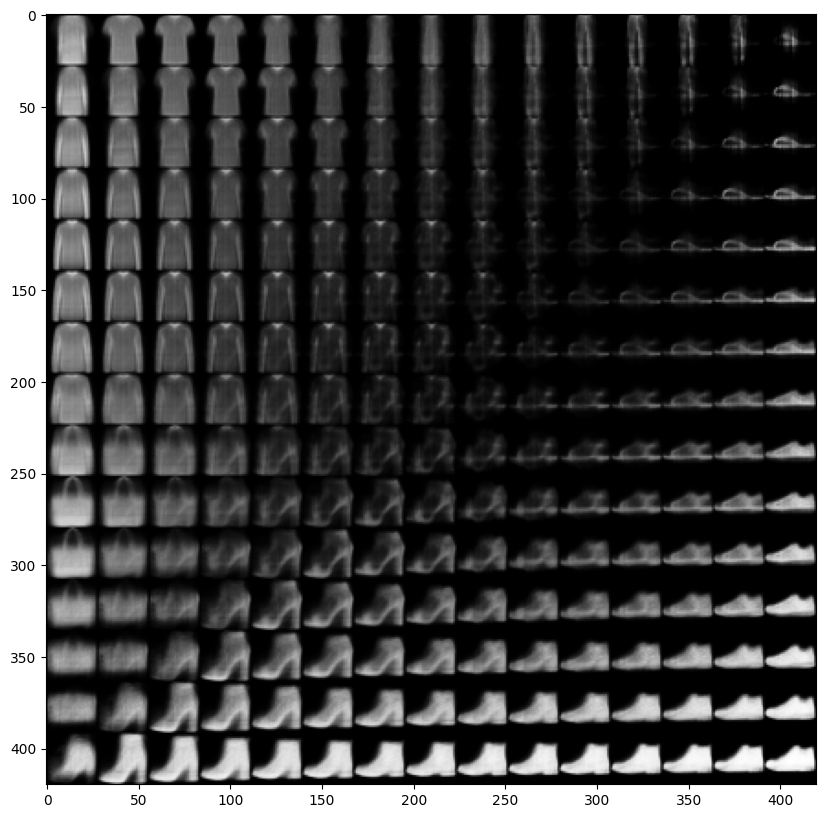

In [13]:
# display a 2D manifold of the digits
#n = 15  # figure with 15x15 digits
n = 15  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# linearly spaced coordinates on the unit square were transformed through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z, since the prior of the latent space is Gaussian
from scipy.stats import norm
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        x_decoded = decoder.predict(z_sample)
        digit = x_decoded[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.show()